This file is to select 3 interesting segments for the ranking

In [19]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pandas as pd
#import spark
from pyspark.sql import SparkSession
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 ass2 BNPL group 28")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

In [20]:
# Read the curated file
curated_csv = spark.read.options(header = True).csv('../data/curated/full_data.csv')

curated_csv = curated_csv.withColumn('dollar_value', curated_csv.dollar_value.cast(FloatType())) \
    .withColumn('avg_personal_income_weekly', curated_csv.avg_personal_income_weekly.cast(FloatType())) \
        .withColumn('take_rate', curated_csv.take_rate.cast(FloatType())) \
            .withColumn('total_population', curated_csv.total_population.cast(IntegerType())) \
                .withColumn('is_fraud', when(curated_csv.is_fraud == 'False', 0).otherwise(1))

In [21]:
popular_segment = curated_csv.groupBy('field').count().orderBy('count',ascending=False)

In [22]:
popular_segment

field,count
tent and awning s...,1526121
"gift, card, novel...",1423773
digital goods: bo...,1087776
"watch, clock, and...",832327
"cable, satellite,...",790324
florists supplies...,758749
"opticians, optica...",731627
"computers, comput...",598586
computer programm...,435736
artist supply and...,405148


In [23]:
popular_segment_name = popular_segment.collect()[0][0]
popular_segment_count = popular_segment.collect()[0][1]

In [24]:
# Get the mean and median of segment order numbers
segment_ordernum_mean = popular_segment.agg({'count': 'avg'}).collect()[0][0]
segment_ordernum_median = popular_segment.agg(expr("percentile(count, 0.5)")).collect()[0][0]

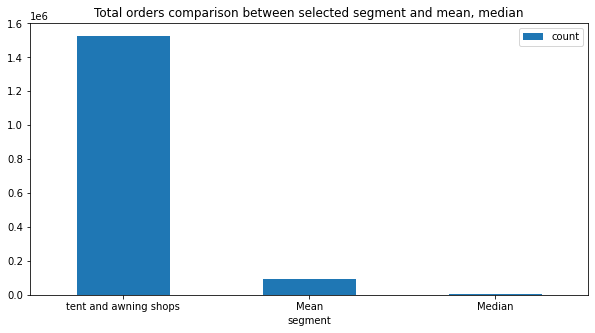

In [25]:
# Visulize the comparison
df = pd.DataFrame({'segment':[popular_segment_name, 'Mean', 'Median'], 
    'count':[popular_segment_count, segment_ordernum_mean, segment_ordernum_median]})
ax = df.plot.bar(x='segment', y='count', rot=0, figsize = [10,5], title = 'Total orders comparison between selected segment and mean, median')

In [26]:
# check the selected segment has more than 10 merchants
merchant_info = spark.read.options(header = True).csv('../data/curated/merchant_info.csv')
field_count = merchant_info.groupBy('field').count()

In [27]:
print(field_count.where(field_count.field == popular_segment_name))

+--------------------+-----+
|               field|count|
+--------------------+-----+
|tent and awning s...|  171|
+--------------------+-----+



Confirmed that the number of merchants in this specific segment is great enough to rank

Next we are interested in the segment which has the greatest revenue

In [28]:
merchant_info = merchant_info.withColumn('transaction_count', merchant_info.transaction_count.cast(IntegerType())) \
    .withColumn('total_revenue', merchant_info.total_revenue.cast(FloatType())) \
        .withColumn('take_rate', merchant_info.take_rate.cast(FloatType())) \
            .withColumn('mean_consumer_income', merchant_info.mean_consumer_income.cast(FloatType())) \
                .withColumn('fraud_count', merchant_info.fraud_count.cast(IntegerType())) \
                    .withColumn('main_business_area_popu', merchant_info.main_business_area_popu.cast(IntegerType()))

In [29]:
segment_revenue = merchant_info.groupBy('field').sum('total_revenue').withColumnRenamed('sum(total_revenue)', 'segment_revenue')

In [30]:
# Sort the revenue in descending order
segment_revenue = segment_revenue.orderBy('segment_revenue',ascending=False)

In [31]:
# The segment with the greatest number of deals also has the greatest revenue
segment_revenue

field,segment_revenue
tent and awning s...,1.2640779604394531E8
artist supply and...,1.0250887800683594E8
"gift, card, novel...",9.677797139746094E7
motor vehicle sup...,9.367390205761719E7
lawn and garden s...,9.268829348730469E7
"computers, comput...",9.224725774609375E7
"furniture, home f...",8.810775269824219E7
florists supplies...,8.659500151171875E7
"books, periodical...",8.318974848242188E7
computer programm...,8.267964002539062E7


Interesting in the segment has greatest revenue per deal

In [32]:
segment_earning_per_merchant = field_count.join(segment_revenue,['field'])

In [33]:
segment_earning_per_merchant = segment_earning_per_merchant.withColumn('avg_revenue_per_merchant', col('segment_revenue') / col('count')) \
    .withColumn('count', segment_earning_per_merchant['count'].cast(IntegerType()))

In [34]:
segment_earning_per_merchant = segment_earning_per_merchant.orderBy('avg_revenue_per_merchant',ascending=False)

In [35]:
segment_earning_per_merchant.where(segment_earning_per_merchant['count']>=10)

field,count,segment_revenue,avg_revenue_per_merchant
tent and awning s...,171,1.2640779604394531E8,739226.8774499726
lawn and garden s...,144,9.268829348730469E7,643668.7047729492
motor vehicle sup...,146,9.367390205761719E7,641602.0688877889
"books, periodical...",151,8.318974848242188E7,550925.4866385554
artist supply and...,187,1.0250887800683594E8,548175.818218374
"computers, comput...",169,9.224725774609375E7,545841.7618112057
"gift, card, novel...",178,9.677797139746094E7,543696.4685250615
"furniture, home f...",166,8.810775269824219E7,530769.594567724
florists supplies...,171,8.659500151171875E7,506403.51761239034
music shops - mus...,149,6.959434489160156E7,467076.14021209104
